# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [6]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [7]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=15, random_state=42)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [8]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [9]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

## 1) Data Preparation

The final task we will need to complete on our neural network is feature scaling.

In [12]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train_transformed_scaled = ss.fit_transform(X_train_transformed)
X_test_transformed_scaled = ss.transform(X_test_transformed)

## 2) Modeling

The next thing we will do is build a neural network classifier.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(11275,))) #input layer
model.add(Dense(units=10, activation='relu')) #hidden layer, the relu activation function helps with speed
model.add(Dense(units=8, activation='relu')) #hidden layer
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(X_train_transformed_scaled, y_train)

model.fit(X_train_transformed_scaled, y_train, validation_data=(X_test_transformed_scaled, y_test), epochs=5, batch_size=50)

Epoch 1/5
300/300 [==============================] - 3s 9ms/step - loss: 0.4482 - accuracy: 0.7916 - val_loss: 0.2634 - val_accuracy: 0.8990
Epoch 2/5
300/300 [==============================] - 2s 5ms/step - loss: 0.1086 - accuracy: 0.9617 - val_loss: 0.2552 - val_accuracy: 0.9010
Epoch 3/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0157 - accuracy: 0.9957 - val_loss: 0.3057 - val_accuracy: 0.8980
Epoch 4/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.3810 - val_accuracy: 0.8910
Epoch 5/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.3882 - val_accuracy: 0.8960


## 3) Model Tuning + Feature Engineering

## 4) Model Evaluation

Lastly, we want to figure out the accuracy score of our model.

Neural Network accuracy score

In [21]:
from sklearn.metrics import accuracy_score

y_hat_test = model.predict_classes(X_test_transformed_scaled)
accuracy_score(y_test, y_hat_test)

0.9064

Random Forest accuracy score

In [19]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


Neural Network confusion matrix

In [22]:
confusion_matrix(y_test, y_hat_test)

array([[2284,  227],
       [ 241, 2248]])

Random Forest confusion matrix

In [18]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## 5) Technical Communication

Based on the initial accuracy score of the neural network, I would suggest continuing the use of your random forest classifier for predicting whether a review is positive or negative. My reasoning for this suggestion is solely based on the random forest classifier receiving a higher accuracy score when compared with the initial neural network score. I want to reiterate that the this is based on initial testing, thus we will continue to tune and perform feature engineering on our neural network model to try and maximize it's performance when compared with the  random forest classifier.

In terms of the mistakes made by the two models, both our neural network and the random forest classifier had a fairly even split between false positives and false negatives. Based on this information, again I would suggest keeping the current random forest model until improvements can be made to the neural network.

The reason I keep emphasizing that we shouldn't throw away our neural network after initial testing is because our neural network needs to be optimized. Once we find the right parameters to optimize it's performance, it should also learn over time, even as data changes. This means that the nueral network will learn by tuning itself to find the right answer on it's own, thus increasing the accuracy of it's predictions. This cannot be done by the current random forest classifier your company is using.

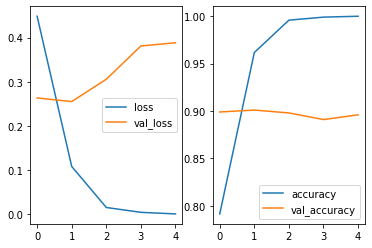

In [27]:
import matplotlib.pyplot as plt

def plot_results(model):
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='loss')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='val_loss')
    
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='accuracy')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='val_accuracy')

    ax2.legend()
    
    
plot_results(model)

This visualization is comparing our accuracy scores and loss function over time. We can see that our model stops learning at about the 2nd epoch.